#  Transpose Convolutions Autoencoder - Granite Background Segmentation

The main objective of this project is apply transpose convolutions for image segmentation, with a tiny data set. This project use some concepts of: Python Programming; Convolutional Models; Image Processing; Neural Networks, Data Augmentation; Batch Normalization.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import random
import cv2 as cv
import tensorflow.contrib.slim as slim

In [2]:
IMG_SIZE = 210
COLOR_CHANNELS = 1

In [3]:
imgs = []
labels = []
for i in ['01', '02', '03', '04', '05']:
    imgs.append(cv.imread('./granito/autoencoder_trainingset/A'+i+'.bmp', 0))
    labels.append(cv.imread('./granito/autoencoder_trainingset/B'+i+'.png', 0))

## Data

The data consists in single color channel images of granite in a black background with some dirty.

The following image is an example:

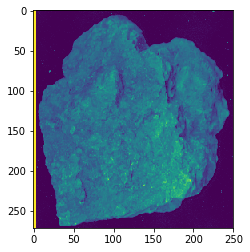

In [30]:
%matplotlib inline
plt.imshow(imgs[2])

## Labels

The label is the binarized granite image, with the dirty manually removed from background.

Example bellow:

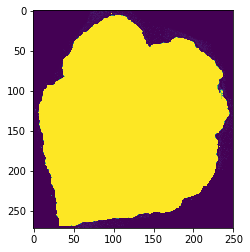

In [31]:
plt.imshow(labels[2])

## Preprocessing and Augmentation

To fit data in the model input images are resized to 210x210x1.
Due to the dataset size, we perform some random rotations for augmentation.

---
About dataset augmentation: https://medium.com/nanonets/how-to-use-deep-learning-when-you-have-limited-data-part-2-data-augmentation-c26971dc8ced

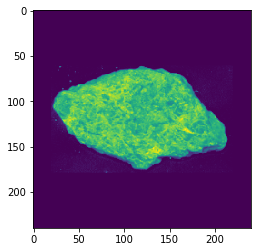

In [32]:
single_image = cv.imread('./granito/autoencoder_trainingset/A07.bmp', 0)
def make_square(img):
    h, w = img.shape
    val = int((h-w)/2)
    if(val > 0):
        img_ = np.pad(img, ((0,0), (val, val)), 'constant', constant_values=(0, 0))
    else:
        img_ = np.pad(img, ((-val, -val), (0,0)), 'constant', constant_values=(0, 0))
    img_ = cv.resize(img_, (200, 200))
    img_ = np.pad(img_, ((20, 20), (20, 20)), 'constant', constant_values=(0, 0))
    return img_
single_image = make_square(single_image)
plt.imshow(single_image)

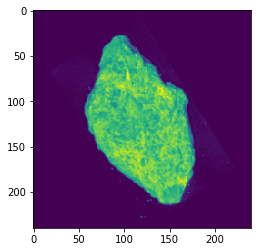

In [33]:
def img_rotate(img, angle):
    num_rows, num_cols = img.shape[:2]
    rotation_matrix = cv.getRotationMatrix2D((num_cols/2, num_rows/2), int(angle*360), 1)
    img_rotation = cv.warpAffine(img, rotation_matrix, (num_cols, num_rows))
    return img_rotation
single_image = img_rotate(single_image, random.random())
plt.imshow(single_image)

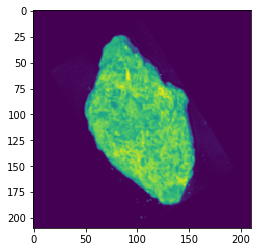

In [34]:
def make_tiny(img):
    img_ = cv.resize(img, (IMG_SIZE, IMG_SIZE))
    return img_
single_image = make_tiny(single_image)
plt.imshow(make_tiny(single_image))

In [35]:
def load_batch(imgs, labels, size):
    batch_x, batch_y = [], []
    for i in range(size):
        r_choice = random.randrange(0, 5)
        image = make_square(imgs[r_choice])
        label = make_square(labels[r_choice])
        r_var = random.random()
        image = img_rotate(image, r_var)
        label = img_rotate(label, r_var)
        image = make_tiny(image)
        label = make_tiny(label)
        batch_x.append(np.array(image).ravel())
        batch_y.append(np.array(label).ravel())
    return batch_x, batch_y

In [36]:
#placeholders
data_ph = tf.placeholder(tf.float32, shape=[None, COLOR_CHANNELS*IMG_SIZE**2])
output_ph = tf.placeholder(tf.float32, shape=[None, COLOR_CHANNELS*IMG_SIZE**2])
learning_rate = tf.placeholder('float', [])

## Model

The model input is a 210x210x1 matrix, with 3 transpose conv and batch normalization layers, one 1x1 conv layer and a sigmoid output. Loss is calculated with min square error, and the optimization algorithm is Adam.

#### About batch normalization: 
* https://arxiv.org/pdf/1502.03167.pdf

#### About transpose convolutions: 
* https://arxiv.org/pdf/1505.04366.pdf,
* http://www.matthewzeiler.com/wp-content/uploads/2017/07/cvpr2010.pdf


In [37]:
def model(input_ph):
    hl0 = tf.reshape(input_ph, [-1, IMG_SIZE, IMG_SIZE, COLOR_CHANNELS])
    hlnorm = slim.batch_norm(hl0)
    hl1 = slim.conv2d_transpose(hlnorm, 60, [9, 9])
    hlnorm = slim.batch_norm(hl1)
    hl2 = slim.conv2d_transpose(hlnorm, 40, [5, 5])
    hlnorm = slim.batch_norm(hl2)
    hl3 = slim.conv2d_transpose(hlnorm, 10, [3, 3])
    hlnorm = slim.batch_norm(hl3)
    hl4 = slim.conv2d(hlnorm, 1, [1, 1])
    ol = tf.nn.sigmoid(hl4)
    ol = tf.reshape(ol, [-1, IMG_SIZE*IMG_SIZE*COLOR_CHANNELS],)
    return ol

In [38]:
ol = model(data_ph)
loss = tf.reduce_mean((ol - output_ph)**2)
train = tf.train.AdamOptimizer(learning_rate).minimize(loss)

In [39]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [ ]:
%matplotlib notebook

batch_size = 5
steps = 5000
rate = 3e-6

fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()

fig.show()
fig.canvas.draw()

with tf.Session() as sess:
    sess.run(init)
    for i in range(steps):
        batch_x, batch_y = load_batch(imgs, labels, batch_size)
        feed = {data_ph:batch_x, output_ph:batch_y, learning_rate:rate}
        sess.run(train, feed_dict=feed)
        
        if i%10 == 0:
            last_loss = sess.run(loss, feed_dict = feed)
#             print(last_loss)
#             if i > 3000:
#                 rate = 3e-4
            pred = sess.run(ol, feed_dict={data_ph:[np.array(single_image).ravel()]})
#             pred = sess.run(ol, feed_dict={data_ph:[np.array(single_image).ravel()]})
            ax.clear()
            ax.imshow(np.reshape(pred, [IMG_SIZE, IMG_SIZE]))
            fig.canvas.draw()
#     pred = [sess.run(ol, feed_dict={data_ph:[np.array(blur_img(test_images[i], blur_level=3.5)).ravel()], batch_s:1}) for i in range(10)]

## Result

### Input

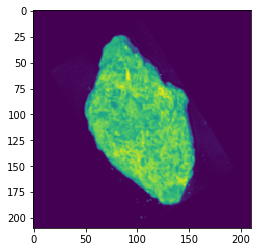

In [41]:
%matplotlib inline
plt.imshow(single_image)

### Output

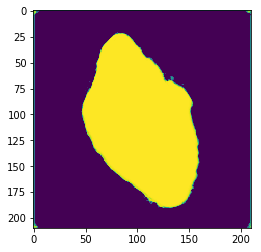

In [42]:
plt.imshow(np.reshape(pred, [IMG_SIZE, IMG_SIZE]))